# Binary Classification of Malginant Mesothelioma

## Importing Packages

In [60]:
import tensorflow
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D,Flatten,Dense,Dropout,BatchNormalization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, confusion_matrix, roc_curve, classification_report, auc, plot_roc_curve
import time
from sklearn import tree
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from scipy import stats
import statistics
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, LabelEncoder
from sklearn import datasets, metrics
from sklearn.feature_selection import SelectFromModel, RFECV, RFE, SelectKBest, chi2, f_classif, mutual_info_classif, SelectKBest
import shap
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

## Exploratory Data Analysis
This section will look into the correlation between continuous variables via. a heatmap, the distribution of the variables, and the boxplot of variables.

<AxesSubplot:>

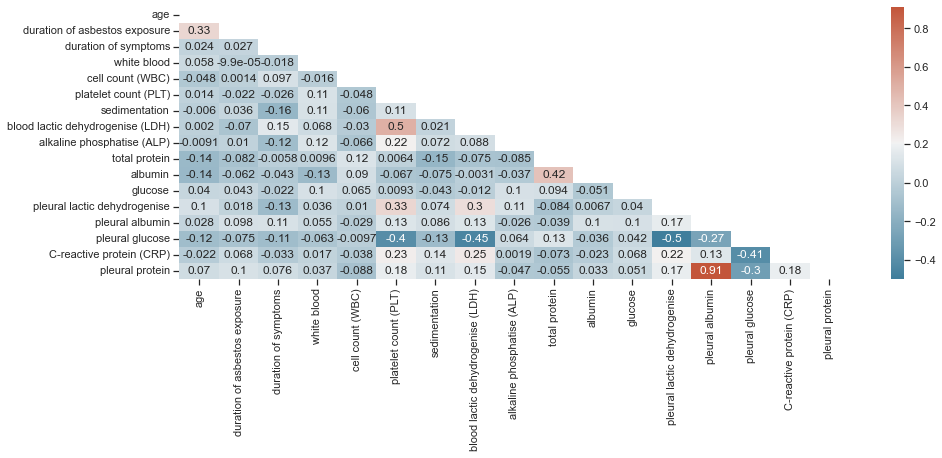

In [61]:
mesdata = pd.read_excel(r'C:/Users/tedch/Documents/Thesis/mesdata.xlsx')
X=mesdata
y=mesdata['class of diagnosis']
transform=['duration of symptoms', 'platelet count (PLT)', 'alkaline phosphatise (ALP)', 'glucose',
           'pleural lactic dehydrogenise', 'cell count (WBC)', 'blood lactic dehydrogenise (LDH)']
X[transform]=X[transform].apply(np.log)

num_feat=['age','duration of asbestos exposure', 'duration of symptoms', 'white blood', 'cell count (WBC)',
          'platelet count (PLT)', 'sedimentation', 'blood lactic dehydrogenise (LDH)', 'alkaline phosphatise (ALP)',
          'total protein', 'albumin', 'glucose', 'pleural lactic dehydrogenise', 'pleural albumin',
          'pleural glucose', 'C-reactive protein (CRP)' , 'pleural protein']

cat_feat=['gender', 'city', 'asbestos exposure', 'type of MM', 'diagnosis method',
       'keep side', 'cytology', 'dyspnoea', 'ache on chest', 'weakness',
       'habit of cigarette', 'performance status', 'hemoglobin (HGB)',
       'dead or not', 'pleural effusion', 'pleural thickness on tomography',
       'pleural level of acidity (pH)', 'class of diagnosis']

X_num = X[num_feat]
X_cat = X[cat_feat]

# Corr heatmap

corr = X_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    data=X_num.corr(), annot=True, mask=mask, cmap=cmap
)



<AxesSubplot:xlabel='keep side', ylabel='count'>

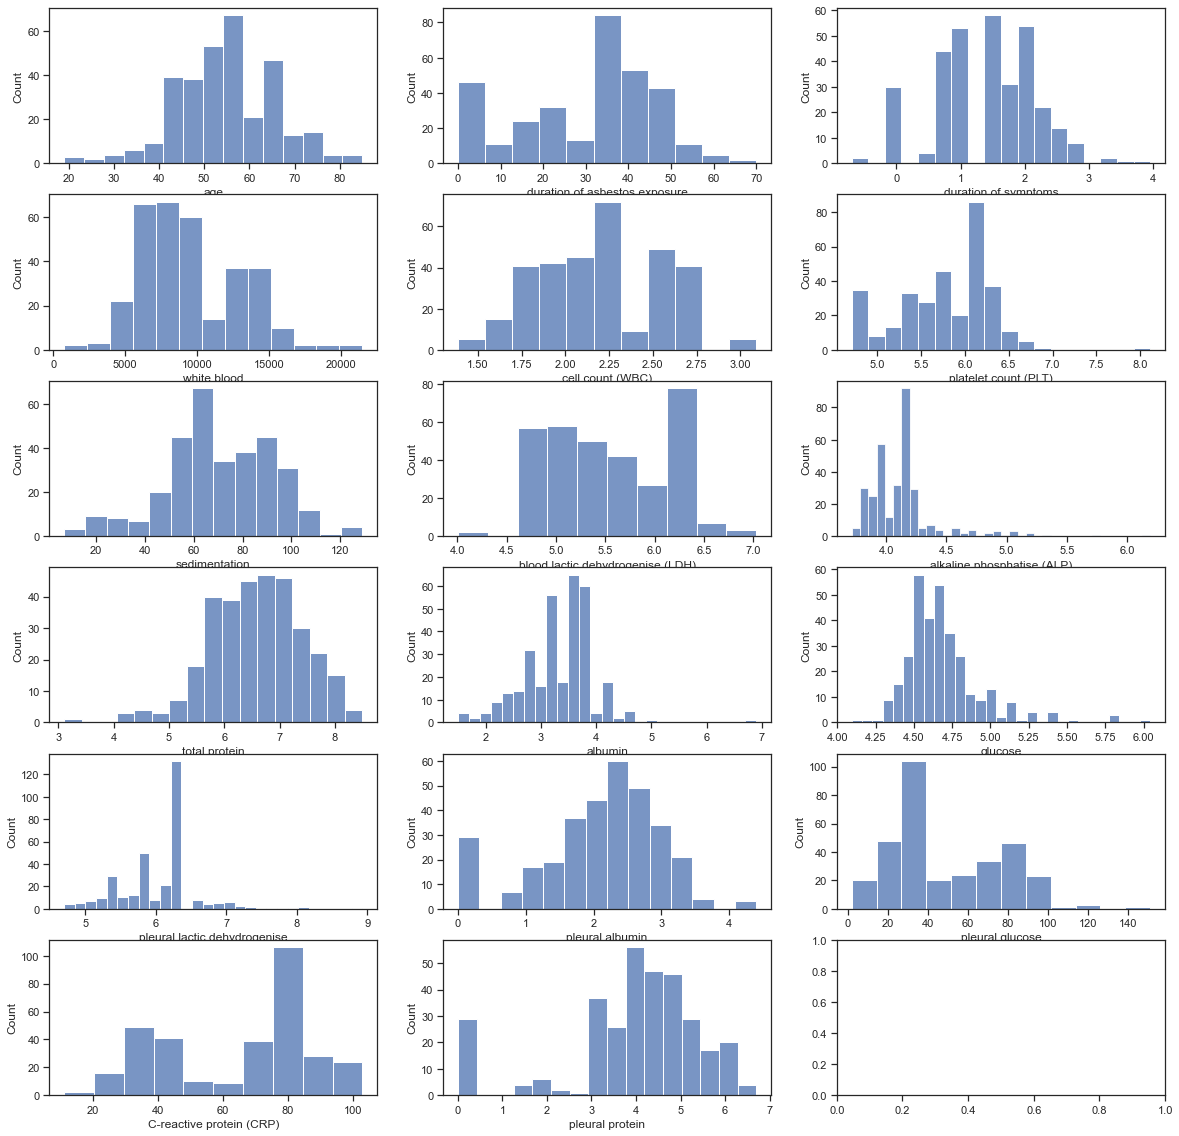

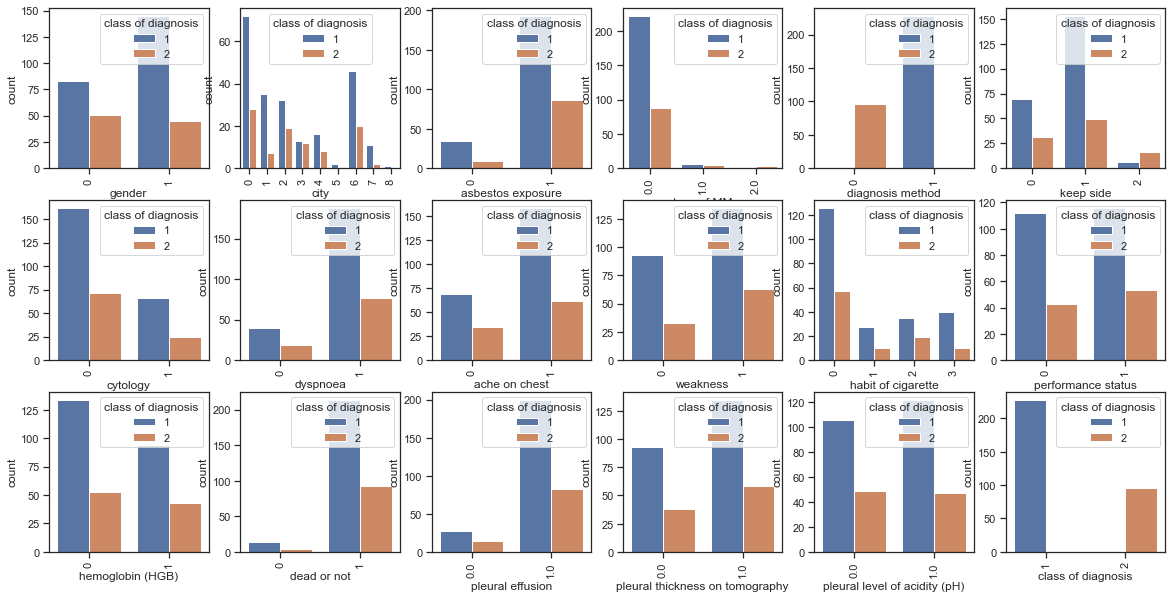

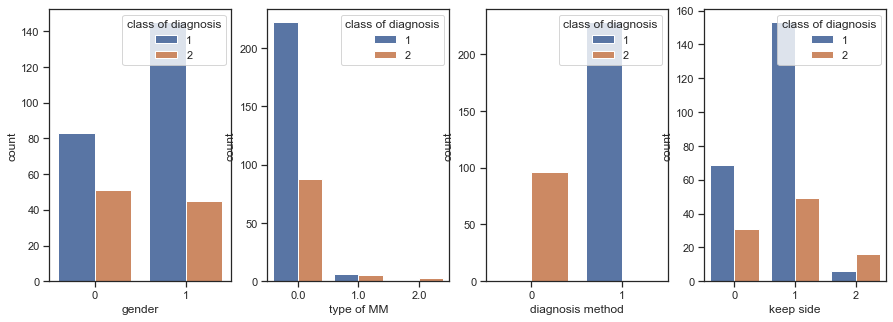

In [62]:

# Num features summary

#X_num.hist(figsize=(6, 3))

fig, ax = plt.subplots(6, 3, figsize=(20, 20))
for ax, feature in zip(ax.flat, X_num.columns):
    sns.histplot(X_num[feature], ax=ax)

# Cat features summary
fig, ax = plt.subplots(3, 6, figsize=(20, 10))
for variable, subplot in zip(cat_feat, ax.flatten()):
    sns.countplot(mesdata[variable], ax=subplot, data=mesdata, hue='class of diagnosis')
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

chisqvar = ['gender', 'type of MM', 'diagnosis method', 'keep side', 'class of diagnosis']

f, axes = plt.subplots(1,4)
sns.countplot(mesdata['gender'], data=mesdata, hue='class of diagnosis', ax=axes[0])
sns.countplot(mesdata['type of MM'], data=mesdata, hue='class of diagnosis', ax=axes[1])
sns.countplot(mesdata['diagnosis method'], data=mesdata, hue='class of diagnosis', ax=axes[2])
sns.countplot(mesdata['keep side'], data=mesdata, hue='class of diagnosis', ax=axes[3])


<AxesSubplot:ylabel='None'>

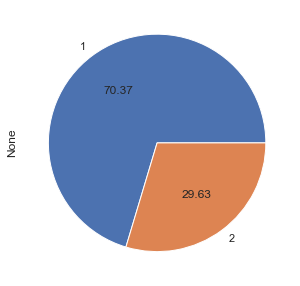

In [63]:

# Target Summary
mesdata.groupby('class of diagnosis').size().plot(kind='pie', autopct='%.2f')


<AxesSubplot:xlabel='class of diagnosis', ylabel='count'>

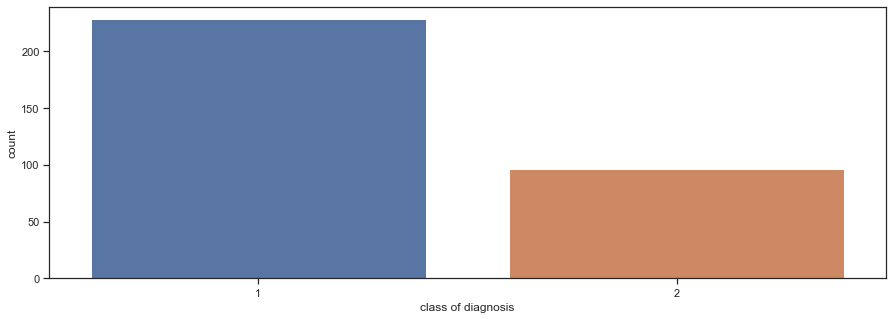

In [64]:
sns.countplot(x="class of diagnosis", data=mesdata)


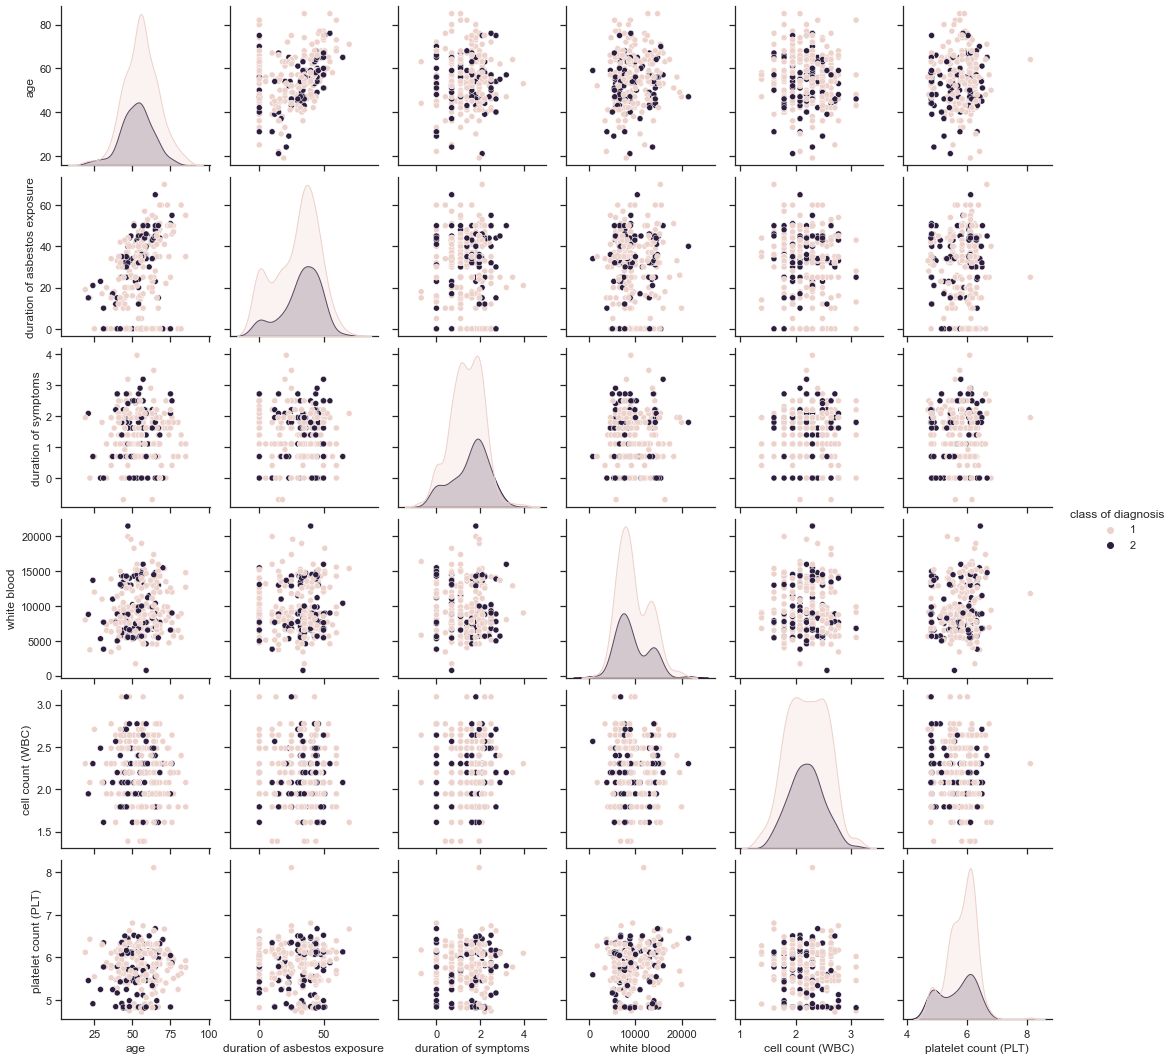

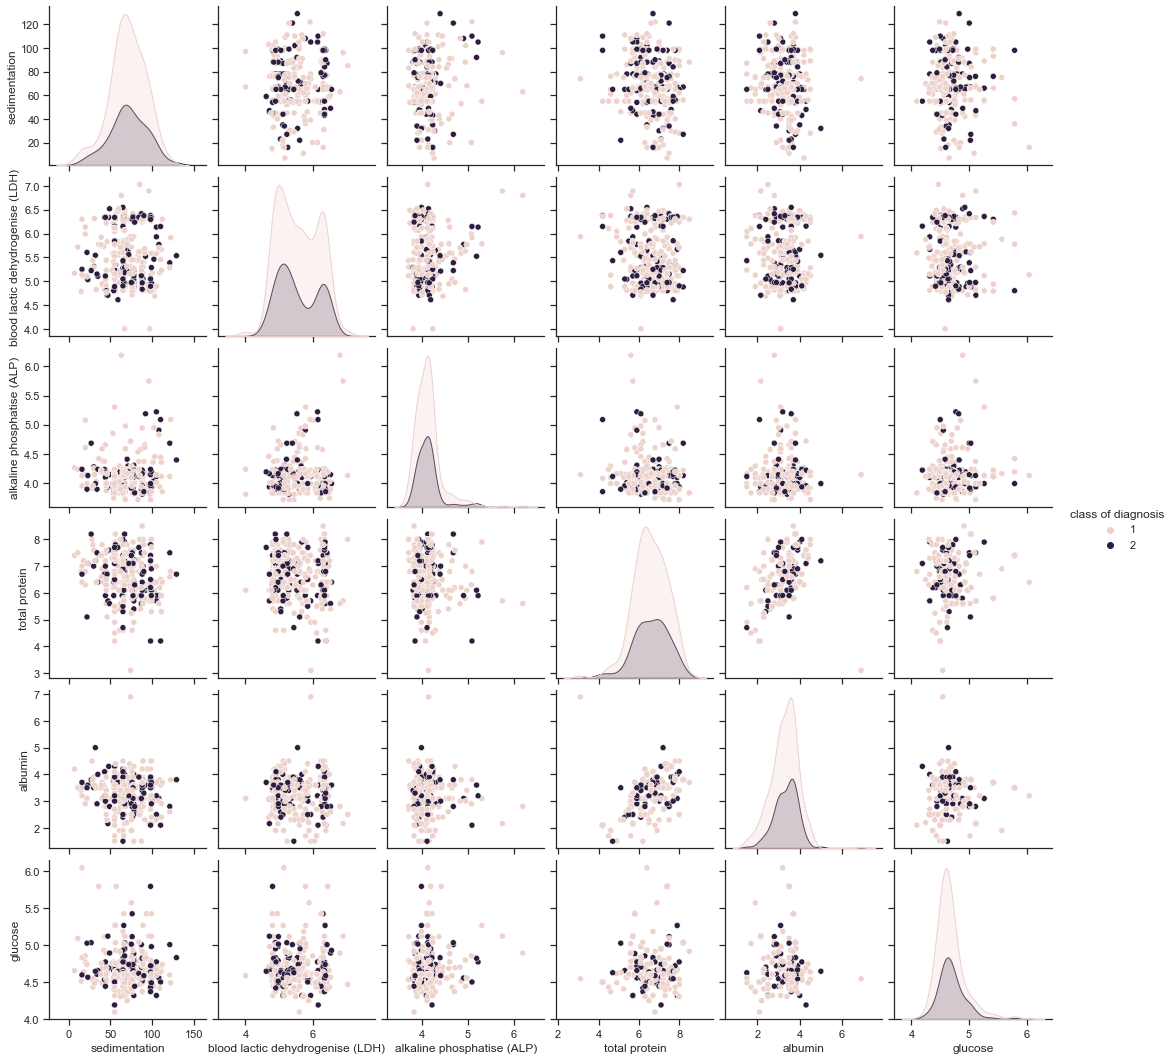

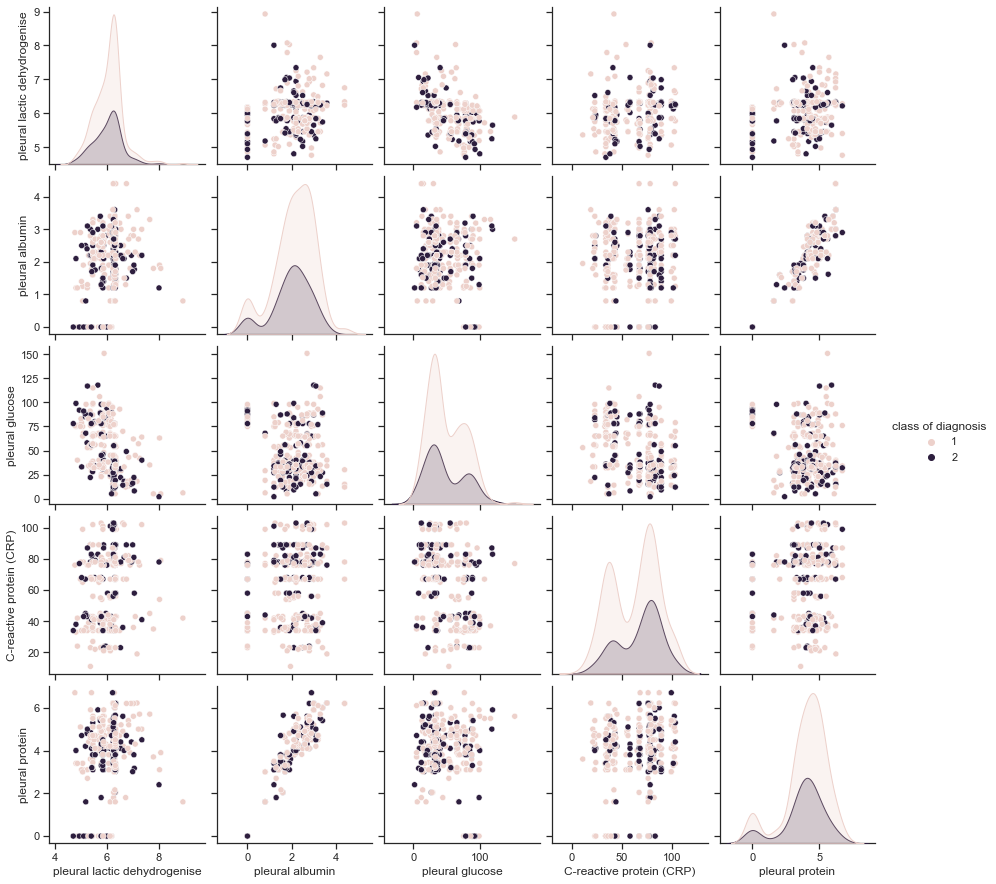

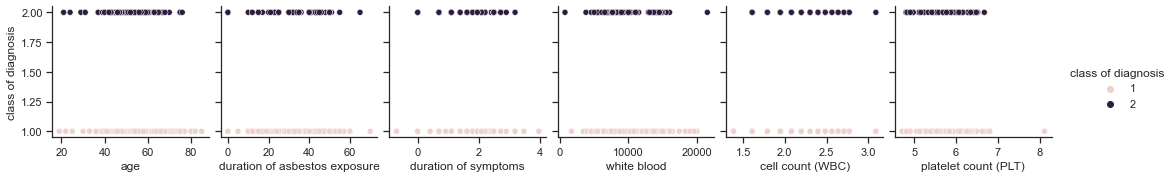

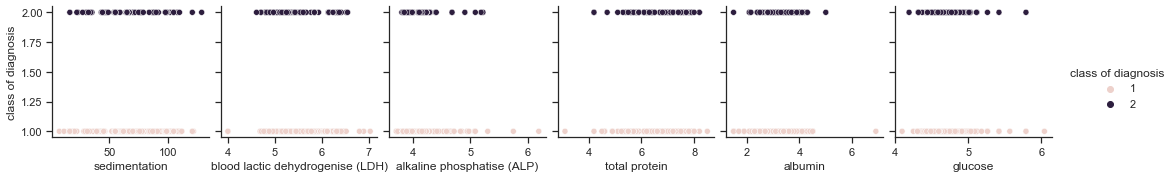

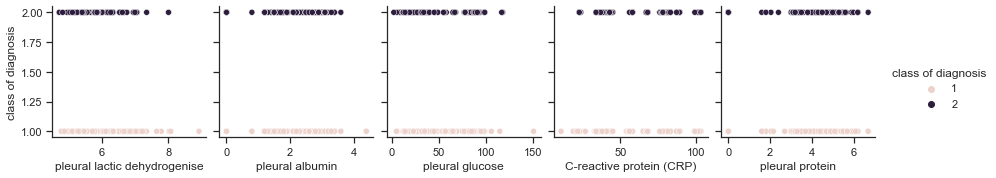

In [65]:

# Outliers Scatter
sns.set_theme(style="ticks")
sns.pairplot(mesdata, y_vars=X_num.iloc[:,0:6], x_vars=X_num.iloc[:,0:6], hue='class of diagnosis')
sns.pairplot(mesdata, y_vars=X_num.iloc[:,6:12], x_vars=X_num.iloc[:,6:12], hue='class of diagnosis')
sns.pairplot(mesdata, y_vars=X_num.iloc[:,12:], x_vars=X_num.iloc[:,12:], hue='class of diagnosis')
sns.pairplot(mesdata, y_vars=['class of diagnosis'], x_vars=X_num.iloc[:,0:6], hue='class of diagnosis')
sns.pairplot(mesdata, y_vars=['class of diagnosis'], x_vars=X_num.iloc[:,6:12], hue='class of diagnosis')
sns.pairplot(mesdata, y_vars=['class of diagnosis'], x_vars=X_num.iloc[:,12:], hue='class of diagnosis')


<AxesSubplot:xlabel='class of diagnosis', ylabel='C-reactive protein (CRP)'>

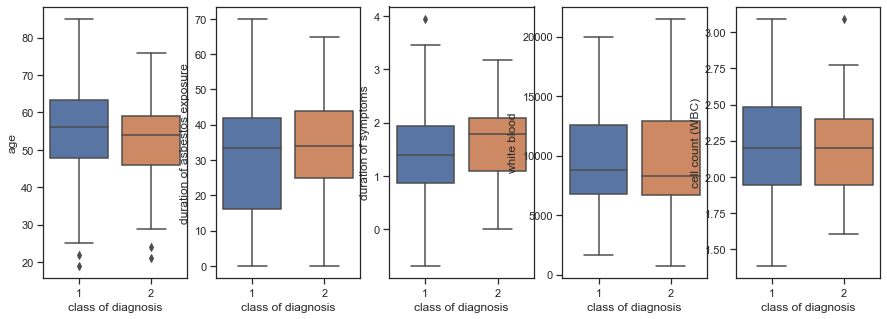

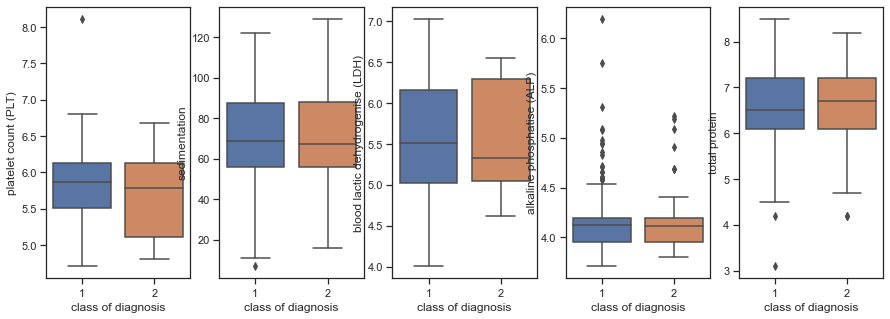

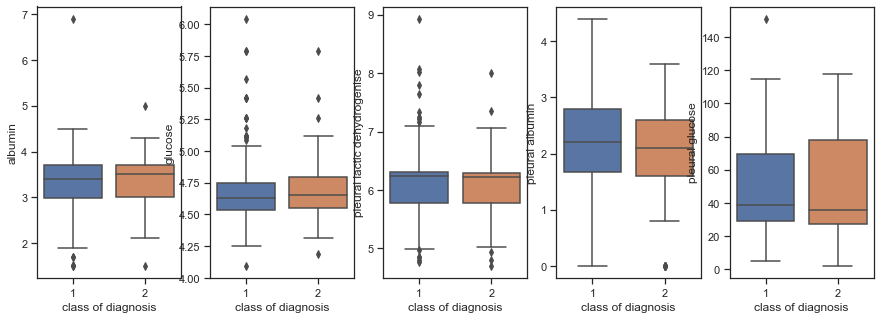

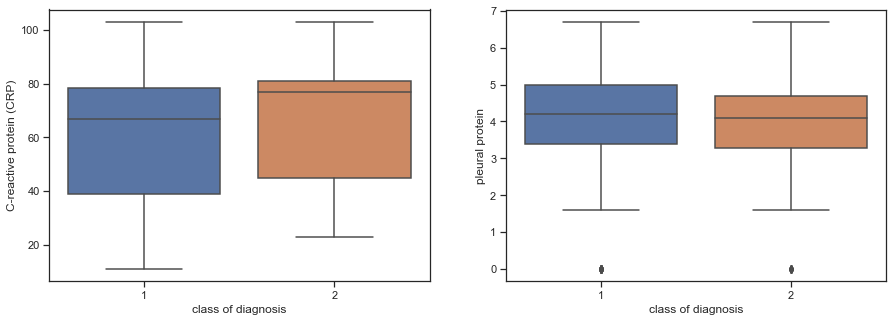

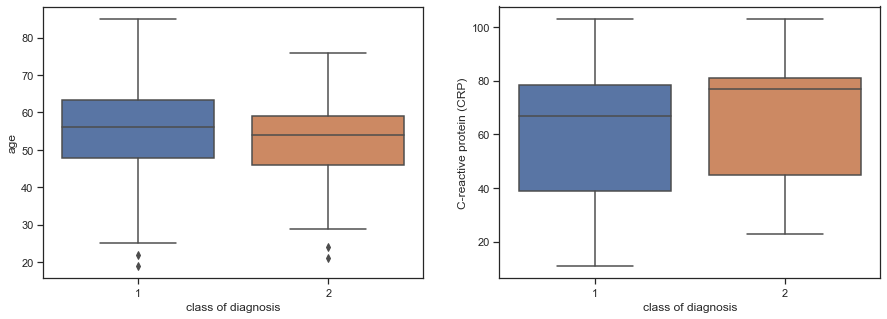

In [66]:
# Boxplot
f, axes = plt.subplots(1,5)
sns.boxplot(y=X_num.iloc[:,0], x=y, data=X_num, orient='v', ax=axes[0])
sns.boxplot(y=X_num.iloc[:,1], x=y, data=X_num, orient='v', ax=axes[1])
sns.boxplot(y=X_num.iloc[:,2], x=y, data=X_num, orient='v', ax=axes[2])
sns.boxplot(y=X_num.iloc[:,3], x=y, data=X_num, orient='v', ax=axes[3])
sns.boxplot(y=X_num.iloc[:,4], x=y, data=X_num, orient='v', ax=axes[4])


f, axes = plt.subplots(1,5)
sns.boxplot(y=X_num.iloc[:,5], x=y, data=X_num, orient='v', ax=axes[0])
sns.boxplot(y=X_num.iloc[:,6], x=y, data=X_num, orient='v', ax=axes[1])
sns.boxplot(y=X_num.iloc[:,7], x=y, data=X_num, orient='v', ax=axes[2])
sns.boxplot(y=X_num.iloc[:,8], x=y, data=X_num, orient='v', ax=axes[3])
sns.boxplot(y=X_num.iloc[:,9], x=y, data=X_num, orient='v', ax=axes[4])

f, axes = plt.subplots(1,5)
sns.boxplot(y=X_num.iloc[:,10], x=y, data=X_num, orient='v', ax=axes[0])
sns.boxplot(y=X_num.iloc[:,11], x=y, data=X_num, orient='v', ax=axes[1])
sns.boxplot(y=X_num.iloc[:,12], x=y, data=X_num, orient='v', ax=axes[2])
sns.boxplot(y=X_num.iloc[:,13], x=y, data=X_num, orient='v', ax=axes[3])
sns.boxplot(y=X_num.iloc[:,14], x=y, data=X_num, orient='v', ax=axes[4])

f, axes = plt.subplots(1,2)
sns.boxplot(y=X_num.iloc[:,15], x=y, data=X_num, orient='v', ax=axes[0])
sns.boxplot(y=X_num.iloc[:,16], x=y, data=X_num, orient='v', ax=axes[1])

f, axes = plt.subplots(1,2)
sns.boxplot(y=mesdata['age'], x=y, data=mesdata, orient='v', ax=axes[0])
sns.boxplot(y=mesdata['C-reactive protein (CRP)'], x=y, data=mesdata, orient='v', ax=axes[1])

## Reading the Data and Data Preprocessing

In [67]:
# Read data
# Transform
mesdata = pd.read_excel(r'C:/Users/tedch/Documents/Thesis/mesdata.xlsx')
mesdata = mesdata.rename(columns={'class of diagnosis': 'diagnosis'})
mesdata.diagnosis.replace({1:0,2:1},inplace=True)
y=mesdata.diagnosis
X=mesdata.drop(['diagnosis', 'diagnosis method', 'pleural protein'],axis=1)
transform=['duration of symptoms', 'platelet count (PLT)', 'alkaline phosphatise (ALP)', 'glucose',
           'pleural lactic dehydrogenise', 'cell count (WBC)', 'blood lactic dehydrogenise (LDH)']
X[transform]=X[transform].apply(np.log)
feature_names = list(X.columns)

X_train,X_test,y_train,y_test= train_test_split(X,y, shuffle=True, test_size=0.2, random_state=42)

sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
oversample = SMOTE(sampling_strategy='minority', random_state=42)
X_train, y_train= oversample.fit_resample(X_train, y_train)

scoring = {'accuracy' : make_scorer(accuracy_score),
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score),
           'f1_score' : make_scorer(f1_score)
           #'roc_auc' : make_scorer(roc_auc_score)
           }

## Define a Function to Get the Metrics

In [68]:
def get_scores(scores):
    scoredict={
        'accuracy' : np.mean(scores.get('test_accuracy'))*100,
        'recall' : np.mean(scores.get('test_recall'))*100,
        'precision' : np.mean(scores.get('test_precision'))*100,
        'f1-score' : np.mean(scores.get('test_f1_score'))*100
        #'roc_auc' : np.mean(scores.get('test_roc_auc'))*100
    }
    print(scoredict)

## Artificial Neural Network Model

2/2 [==============================] - 0s 1000us/step
--- 1.2854222910744804 seconds ---
{'accuracy': 83.24175824175823, 'recall': 85.93591282666912, 'precision': 70.0455684666211, 'f1-score': 76.41602279232941}


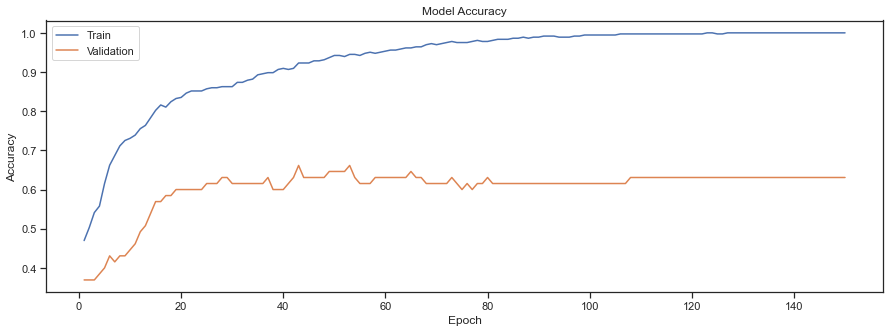

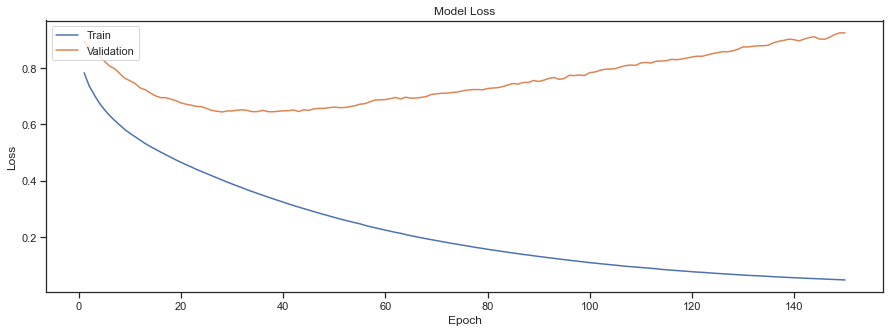

In [69]:
# ANN
tensorflow.random.set_seed(110)

def create_model():
    model = Sequential()
    model.add(Dense(units=32, activation='relu'))
    #model.add(Dense(units=16, activation='relu'))
    #model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=KerasClassifier(build_fn=create_model, epochs=150, batch_size=32, verbose=0)
history = model.fit(X_train,y_train,batch_size=32,epochs=150,verbose=0,validation_data=(X_test,y_test))


# Scores
start_time = time.time()
scores = cross_validate(model, X_train, y_train, cv=7, scoring=scoring)
print("--- %s seconds ---" % ((time.time() - start_time)/7))

get_scores(scores)


# Loss graph

epochs=150

epochRange = range(1,epochs+1)
plt.plot(epochRange,history.history['accuracy'])
plt.plot(epochRange,history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

plt.plot(epochRange,history.history['loss'])
plt.plot(epochRange,history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()
